In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

### **Original problem**: Select top 1 candidate

**Selection Strategy**: Divide the candidate pool into exploration and exploitation:
  - Exploration: Explore the first ~37% (=1/e) of the candidate pool, do not choose anyone.
  - Exploitation (the rest): Select the first candidate that is better than exploration pool.

In [17]:
'''Simulate 1 run of original secretary problem'''

def simulate_one_original_problem(num_candidates=100, strategy_fraction = 1 / np.e):
    simulation_result = []
    # Generate random quality scores for candidates
    quality_scores=np.random.uniform(0, 1, num_candidates)
    # Identify the best candidate's quality score
    true_best = np.max(quality_scores)

    # Determine the number of candidates to explore based on the strategy fraction and the best explored quality score
    explore_size = int(num_candidates * strategy_fraction)
    best_explored = np.max(quality_scores[:explore_size])

    # Select the candidate with the highest quality score after the exploration phase
    selected_candidate = quality_scores[-1]  # Default to last candidate if none selected earlier
    total_search = explore_size # Count of candidates evaluated after exploration
    for i in quality_scores[explore_size:]:
        total_search += 1
        if i >= best_explored:
            selected_candidate = i
            break

    # Check rank of the selected candidate
    rank = (quality_scores > selected_candidate).sum() + 1

    # Append the results to the simulation_results list
    simulation_result.append({
        'pool_size': num_candidates,
        'selected_candidate': selected_candidate,
        'selected_rank': rank,
        'is_best_candidate': selected_candidate == true_best,
        'gap_to_best': true_best - selected_candidate,
        'num_search': total_search,
        'search_time': total_search / num_candidates
    })
    return pd.DataFrame(simulation_result)

In [18]:
'''Simulate 1000 runs of original secretary problem'''

def run_original_simulations(num_simulations=1000, num_candidates=[100], strategy_fraction=[1/np.e]):
    np.random.seed(11072003)
    all_results = pd.DataFrame()
    for _ in range(num_simulations):
        for num_candidate in num_candidates:
            for frac in strategy_fraction:
                result = simulate_one_original_problem(num_candidate, frac)
                all_results = pd.concat([all_results, result], ignore_index=True)
    return all_results

In [19]:
# Run the original secretary problem simulation with pool sizes of 100 and 1000
original_secretary_results = run_original_simulations(num_candidates=[100, 1000], num_simulations=1000, strategy_fraction=[1/np.e])
original_secretary_results

,pool_size,selected_candidate,selected_rank,is_best_candidate,gap_to_best,num_search,search_time
0,100,0.967064,1,True,0.000000,96,0.960
1,1000,0.998764,1,True,0.000000,583,0.583
2,100,0.359544,66,False,0.626235,100,1.000
3,1000,0.996814,2,False,0.001403,735,0.735
4,100,0.978960,2,False,0.016288,37,0.370
...,...,...,...,...,...,...,...
1995,1000,0.236351,764,False,0.762172,1000,1.000
1996,100,0.952333,3,False,0.047024,71,0.710
1997,1000,0.999909,1,True,0.000000,961,0.961
1998,100,0.995055,1,True,0.000000,92,0.920


In [20]:
# Analyze the results
original_secretary_results_summary = original_secretary_results.groupby('pool_size').agg(
    success_rate=('is_best_candidate', 'mean'),
    avg_gap_to_best=('gap_to_best', 'mean'),
    avg_search_time=('search_time', 'mean')
).reset_index()
original_secretary_results_summary

,pool_size,success_rate,avg_gap_to_best,avg_search_time
0,100,0.386,0.173780,0.719320
1,1000,0.377,0.180871,0.726193


### **New Problem**: Select a good enough candidate

There are 3 selection methods:
- Select the first above the exploration pool
- Select the first above the top-k% threshold
- Select the first candidate who is in top-k of observed candidates so far

In [21]:
'''Simulate 1 run of new secretary problem'''
def simulate_one_new_problem(
    num_candidates=100, 
    strategy_fraction=1/np.e, 
    k_percent=0.01, 
    selection_method='first_above_k_threshold'):
    simulation_result = []
    # Generate random quality scores for candidates
    quality_scores=np.random.uniform(0, 1, num_candidates)

    # Identify the best candidate's quality score
    true_best = np.max(quality_scores)

    # Determine the k-th threshold quality score
    sorted_scores = sorted(quality_scores, reverse=True)
    k = int(num_candidates * k_percent)
    k_threshold = sorted_scores[k-1]

    # Determine the number of candidates to explore based on the strategy fraction and the best explored quality score
    explore_size = int(num_candidates * strategy_fraction)
    explored_scores = quality_scores[:explore_size]
    selected_candidate = quality_scores[-1]  # Default to last candidate if none selected earlier
    total_search = explore_size # Count of candidates evaluated after exploration

    if selection_method == 'first_above_k_threshold':
        estimated_k_threshold = np.quantile(explored_scores, 1 - k_percent)
        # Select the first candidate above the estimated k-th threshold
        for i in quality_scores[explore_size:]:
            total_search += 1
            if i >= estimated_k_threshold:
                selected_candidate = i
                break

    elif selection_method == 'rank-based':
        best_explored = np.max(explored_scores)
        seen_scores = explored_scores.copy()
        for i in quality_scores[explore_size:]:
            total_search += 1
            seen_scores = np.append(seen_scores, i)
            # rank i-th candidate among seen candidates
            sorted_seen = sorted(seen_scores, reverse=True)
            rank_in_seen = sorted_seen.index(i) + 1
            # compute top-k among seen pool
            k_seen = max(int(len(seen_scores) * k_percent), 1)
            # Select the first candidate who is in top-k of seen candidates or above the best explored
            if rank_in_seen <= k_seen:  # realistic rank rule
                selected_candidate = i
                break

    else:  # 'first_above_best_explored' - original strategy
        best_explored = np.max(explored_scores)
        # Select the candidate with the highest quality score after the exploration phase
        for i in quality_scores[explore_size:]:
            total_search += 1
            if i >= best_explored:
                selected_candidate = i
                break

    # Check rank of the selected candidate
    rank = (quality_scores > selected_candidate).sum()+1

    #Append the results to the simulation_results list
    simulation_result.append({
        'pool_size': num_candidates,
        'strategy_fraction': strategy_fraction,
        'top_k_threshold': k_threshold,
        'selected_candidate': selected_candidate,
        'selected_rank': rank,
        'is_top_k_candidate': selected_candidate >= k_threshold,
        'is_best_candidate': selected_candidate == true_best,
        'gap_to_best': (true_best - selected_candidate) / true_best,
        'gap_to_k_threshold': (k_threshold - selected_candidate) / k_threshold,
        'num_search': total_search,
        'search_time': total_search / num_candidates,
    })
    return pd.DataFrame(simulation_result)

In [22]:
'''Simulate 1000 runs of new secretary problem'''
def run_new_simulations(
    num_simulations=1000, 
    num_candidates=[100], 
    strategy_fraction=[1/np.e], 
    k_percent=[0.01], 
    selection_method='first_above_best_explored', seed=None):
    if seed is not None:
        np.random.seed(seed)
    else:
      np.random.seed(11072003)
    all_results = pd.DataFrame()
    for _ in range(num_simulations):
        for num_candidate in num_candidates:
            for frac in strategy_fraction:
                for k in k_percent:
                    result = simulate_one_new_problem(num_candidate, frac, k, selection_method)
                    result['strategy_fraction'] = frac
                    result['pool_size'] = num_candidate
                    result['k_percent'] = k
                    result['selection_method'] = selection_method
                    all_results = pd.concat([all_results, result], ignore_index=True)
    return all_results

Approach: simulate  what-if scenarios with below parameters:
- Total number of candidates: ***num_candidates = [100, 500, 1000]***
- The percentage of exploration pool: ***strategy_fraction = [0.1, 0.2, 0.3, 1/np.e, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]***
- Acceptance criteria: ***k_percent = [0.01, 0.05, 0.1]***
- Selection method: 
  - ***'rank-based method'***
  - ***'first_above_best_explored'***
  - ***'first_above_k_threshold'***

In [23]:
# Run the new secretary problem simulation: 'first_above_best_explored' method
evaluate_best_strategy_results = run_new_simulations(num_candidates=[100,500,1000], strategy_fraction = [0.1, 0.2, 0.3, 1/np.e, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], k_percent=[0.01, 0.05, 0.1], selection_method='first_above_best_explored')

In [24]:
evaluate_best_strategy_results_summary = evaluate_best_strategy_results.groupby(['strategy_fraction','pool_size','k_percent']).agg(
    success_rate_topk_candidate=('is_top_k_candidate', 'mean'),
    success_rate_best_candidate=('is_best_candidate', 'mean'),
    avg_gap_to_k_threshold=('gap_to_k_threshold', 'mean'),
    avg_gap_to_best=('gap_to_best', 'mean'),
    avg_search_time=('search_time', 'mean')
).reset_index()
evaluate_best_strategy_results_summary

,strategy_fraction,pool_size,k_percent,success_rate_topk_candidate,success_rate_best_candidate,avg_gap_to_k_threshold,avg_gap_to_best,avg_search_time
0,0.1,100,0.01,0.204,0.204,0.099995,0.099995,0.337320
1,0.1,100,0.05,0.620,0.259,0.056032,0.094063,0.348680
2,0.1,100,0.10,0.808,0.230,-0.006304,0.085934,0.336380
3,0.1,500,0.01,0.592,0.226,0.059397,0.066984,0.342494
4,0.1,500,0.05,0.882,0.221,0.016163,0.063217,0.342908
...,...,...,...,...,...,...,...,...
85,0.9,500,0.05,0.135,0.088,0.445576,0.472150,0.995628
86,0.9,500,0.10,0.160,0.082,0.416187,0.473243,0.995536
87,0.9,1000,0.01,0.100,0.092,0.447820,0.452839,0.995843
88,0.9,1000,0.05,0.147,0.101,0.424433,0.452824,0.994925


In [25]:
# Run the new secretary problem simulation: 'first_above_k_threshold' method
evaluate_topk_strategy_results = run_new_simulations(num_candidates=[100,500,1000], strategy_fraction = [0.1, 0.2, 0.3, 1/np.e, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], k_percent=[0.01, 0.05, 0.1], selection_method='first_above_k_threshold')


In [26]:
evaluate_topk_strategy_results_summary = evaluate_topk_strategy_results.groupby(['strategy_fraction','pool_size','k_percent']).agg(
    success_rate_topk_candidate=('is_top_k_candidate', 'mean'),
    success_rate_best_candidate=('is_best_candidate', 'mean'),
    avg_gap_to_k_threshold=('gap_to_k_threshold', 'mean'),
    avg_gap_to_best=('gap_to_best', 'mean'),
    avg_search_time=('search_time', 'mean')
).reset_index()
evaluate_topk_strategy_results_summary

,strategy_fraction,pool_size,k_percent,success_rate_topk_candidate,success_rate_best_candidate,avg_gap_to_k_threshold,avg_gap_to_best,avg_search_time
0,0.1,100,0.01,0.174,0.174,0.067328,0.067328,0.292720
1,0.1,100,0.05,0.537,0.138,0.027060,0.066111,0.233340
2,0.1,100,0.10,0.690,0.088,-0.012754,0.080302,0.196620
3,0.1,500,0.01,0.515,0.119,0.016689,0.024614,0.227420
4,0.1,500,0.05,0.783,0.038,-0.018027,0.030610,0.141088
...,...,...,...,...,...,...,...,...
85,0.9,500,0.05,0.908,0.030,0.014751,0.061934,0.936118
86,0.9,500,0.10,0.990,0.019,-0.054216,0.049158,0.920190
87,0.9,1000,0.01,0.641,0.059,0.157130,0.164796,0.959137
88,0.9,1000,0.05,0.979,0.024,-0.021765,0.028445,0.919802


In [27]:
evaluate_rankbased_strategy_results = run_new_simulations(num_candidates=[100,500,1000], strategy_fraction = [0.1, 0.2, 0.3, 1/np.e, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], k_percent=[0.01, 0.05, 0.1], selection_method='rank-based')

In [28]:
evaluate_rankbased_strategy_results_summary = evaluate_rankbased_strategy_results.groupby(['strategy_fraction','pool_size','k_percent']).agg(
    success_rate_topk_candidate=('is_top_k_candidate', 'mean'),
    success_rate_best_candidate=('is_best_candidate', 'mean'),
    avg_gap_to_k_threshold=('gap_to_k_threshold', 'mean'),
    avg_gap_to_best=('gap_to_best', 'mean'),
    avg_search_time=('search_time', 'mean')
).reset_index()
evaluate_rankbased_strategy_results_summary

,strategy_fraction,pool_size,k_percent,success_rate_topk_candidate,success_rate_best_candidate,avg_gap_to_k_threshold,avg_gap_to_best,avg_search_time
0,0.1,100,0.01,0.204,0.204,0.099995,0.099995,0.337320
1,0.1,100,0.05,0.691,0.211,0.005830,0.045840,0.306290
2,0.1,100,0.10,0.848,0.111,-0.041989,0.053787,0.226400
3,0.1,500,0.01,0.662,0.184,0.012696,0.020679,0.297452
4,0.1,500,0.05,0.867,0.046,-0.024067,0.024859,0.147146
...,...,...,...,...,...,...,...,...
85,0.9,500,0.05,0.917,0.030,0.015366,0.062521,0.937314
86,0.9,500,0.10,0.990,0.019,-0.054754,0.048676,0.920534
87,0.9,1000,0.01,0.626,0.059,0.179667,0.187129,0.962263
88,0.9,1000,0.05,0.985,0.024,-0.021945,0.028273,0.919890


In [36]:
evaluate_topk_strategy_results_summary['selection_method'] = 'first_above_k_threshold'
evaluate_best_strategy_results_summary['selection_method'] = 'first_above_best_explored'
evaluate_rankbased_strategy_results_summary['selection_method'] = 'rank-based'
# Summarize the results
summary_df = pd.concat([
    evaluate_best_strategy_results_summary,
    evaluate_topk_strategy_results_summary,
    evaluate_rankbased_strategy_results_summary])
summary_df.head()

,strategy_fraction,pool_size,k_percent,success_rate_topk_candidate,success_rate_best_candidate,avg_gap_to_k_threshold,avg_gap_to_best,avg_search_time,selection_method
0,0.1,100,0.01,0.204,0.204,0.099995,0.099995,0.337320,first_above_best_explored
1,0.1,100,0.05,0.620,0.259,0.056032,0.094063,0.348680,first_above_best_explored
2,0.1,100,0.10,0.808,0.230,-0.006304,0.085934,0.336380,first_above_best_explored
3,0.1,500,0.01,0.592,0.226,0.059397,0.066984,0.342494,first_above_best_explored
4,0.1,500,0.05,0.882,0.221,0.016163,0.063217,0.342908,first_above_best_explored


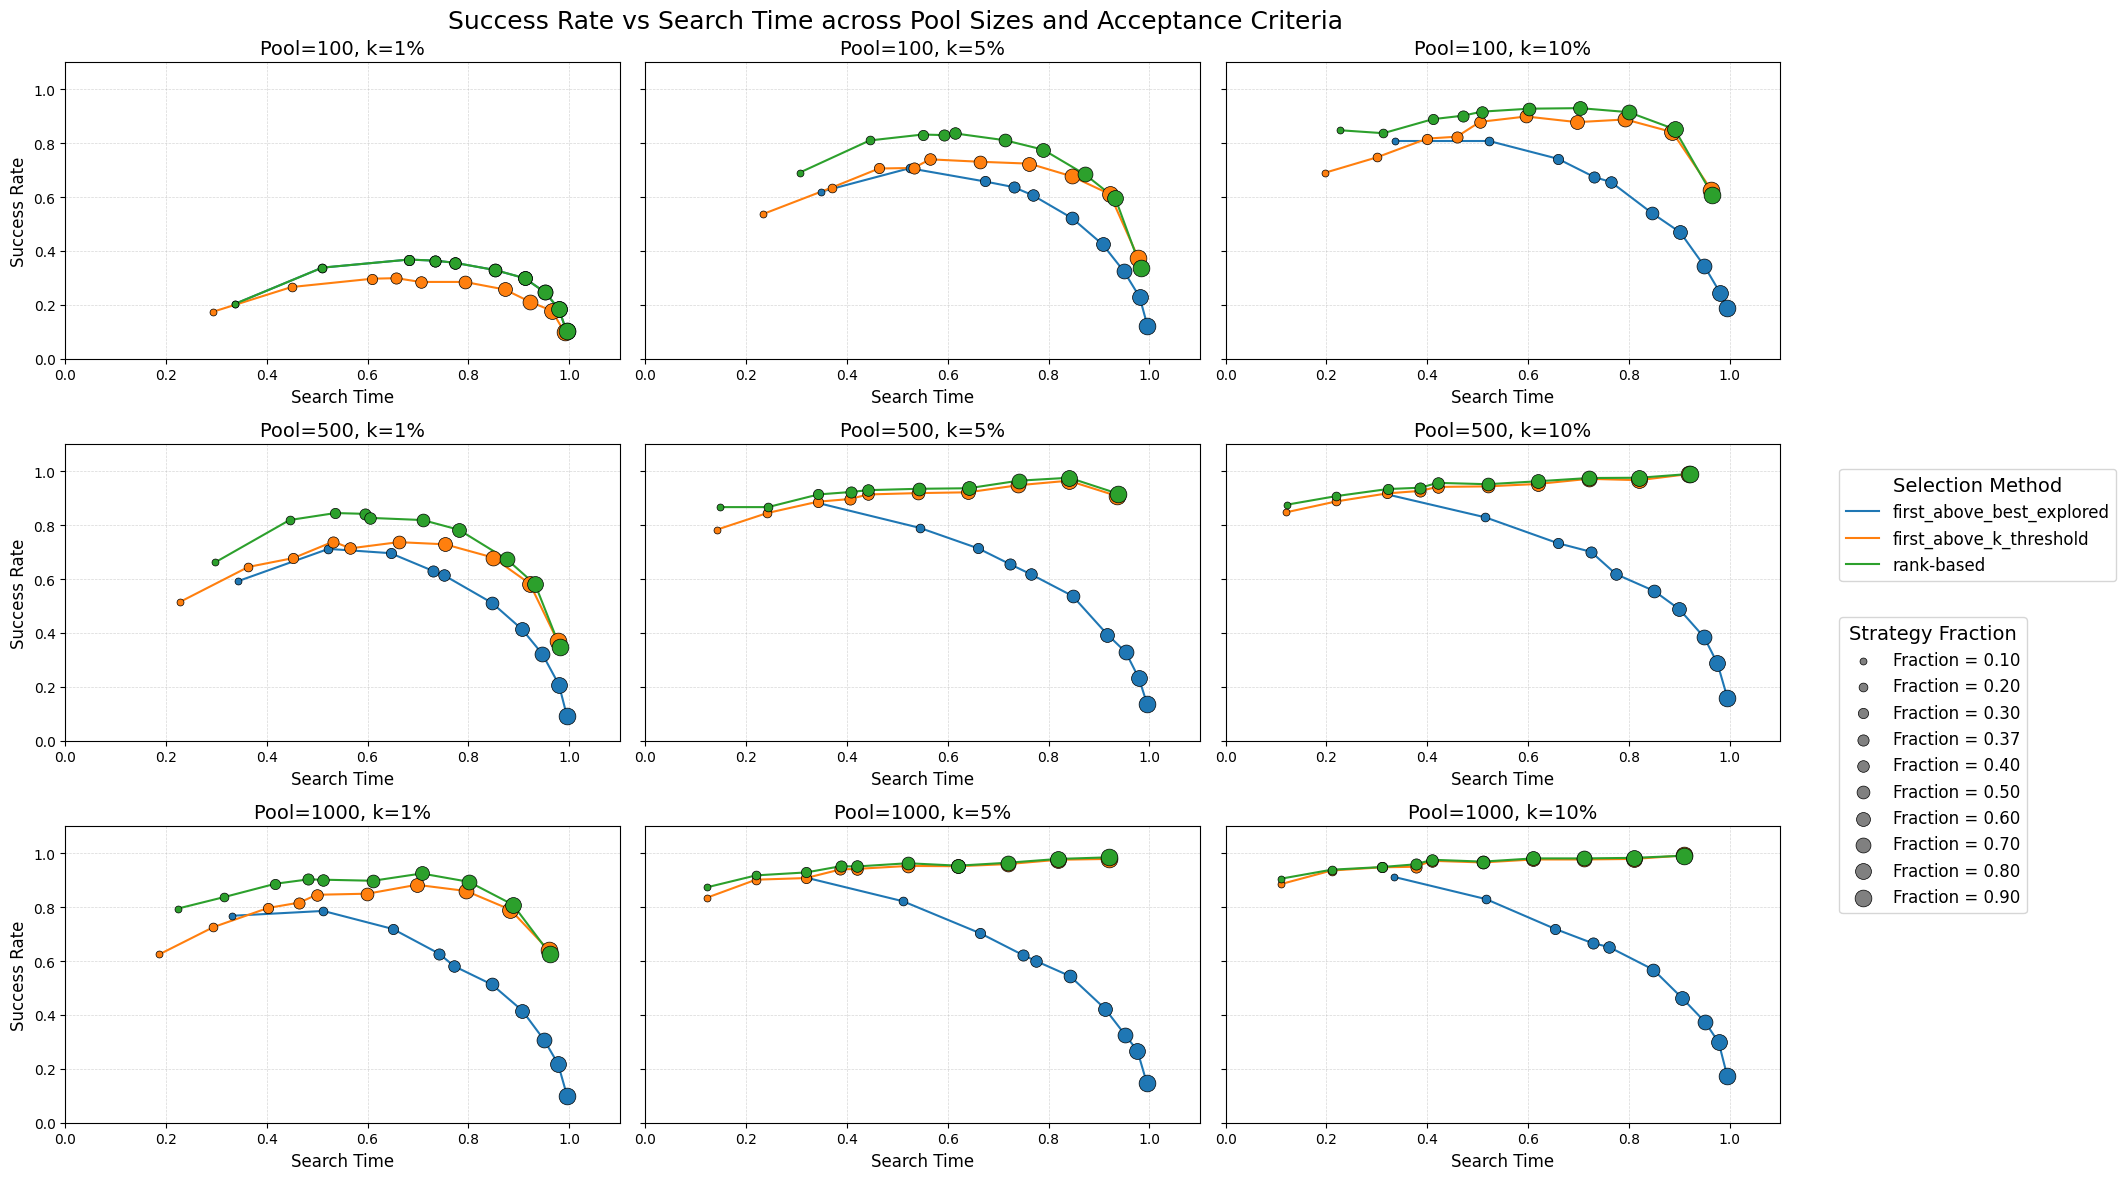

In [102]:
def plot_success_rate_vs_search_time(summary_df):
    pool_sizes = [100, 500, 1000]
    k_values = [0.01, 0.05, 0.10]
    selection_methods = summary_df['selection_method'].unique()
    fractions = sorted(summary_df['strategy_fraction'].unique())

    def size_from_fraction(frac):
        return 10 + frac * 150

    fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=False, sharey=True)
    fig.suptitle("Success Rate vs Search Time across Pool Sizes and Acceptance Criteria", fontsize=18)
    line_handles, line_labels = [], []

    # -----------------------
    # DRAW SUBPLOTS
    # -----------------------
    for i, pool in enumerate(pool_sizes):
        for j, k in enumerate(k_values):
            
            ax = axes[i, j]
            sub = summary_df[(summary_df.pool_size == pool) & (summary_df.k_percent == k)]
            
            for method in selection_methods:

                sub_method = sub[sub.selection_method == method].sort_values("strategy_fraction")

                # line 
                line = sns.lineplot(
                    data=sub_method,
                    x='avg_search_time',
                    y='success_rate_topk_candidate',
                    ax=ax,
                    label=method,
                    legend=False
                )
                # save line legend ONCE
                if method not in line_labels:
                    line_handles.append(line.lines[-1])
                    line_labels.append(method)

                # markers
                for frac in fractions:
                    point = sub_method[sub_method.strategy_fraction == frac]
                    if len(point) == 0:
                        continue
                    
                    ax.scatter(
                        point['avg_search_time'],
                        point['success_rate_topk_candidate'],
                        s=size_from_fraction(frac),
                        color=line.lines[-1].get_color(),
                        edgecolor='black',
                        linewidth=0.5,
                        zorder=5
                    )

            ax.set_title(f"Pool={pool}, k={int(k*100)}%", fontsize=14)
            ax.set_ylim(0, 1.1)
            ax.set_xlim(0, 1.1)
            ax.set_xlabel("Search Time", fontsize=12)
            ax.set_ylabel("Success Rate", fontsize=12)
            ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)


    # -----------------------
    # CREATE LEGEND
    # -----------------------


    # LINE LEGEND
    fig.legend(
        line_handles, line_labels,
        loc="center left",
        bbox_to_anchor=(1.02, 0.55),
        title="Selection Method",
        fontsize=12,
        title_fontsize=14
    )

    # MARKER LEGEND
    marker_handles = []
    marker_labels = []

    for frac in fractions:
        dummy = plt.scatter(
            [], [], 
            s=size_from_fraction(frac),
            color="gray",
            edgecolor="black",
            linewidth=0.5
        )
        marker_handles.append(dummy)
        marker_labels.append(f"Fraction = {frac:.2f}")

    fig.legend(
        marker_handles, marker_labels,
        loc="center left",
        bbox_to_anchor=(1.02, 0.35),
        title="Strategy Fraction",
        fontsize=12,
        title_fontsize=14
    )

    plt.tight_layout()
    plt.show()
plot_success_rate_vs_search_time(summary_df)

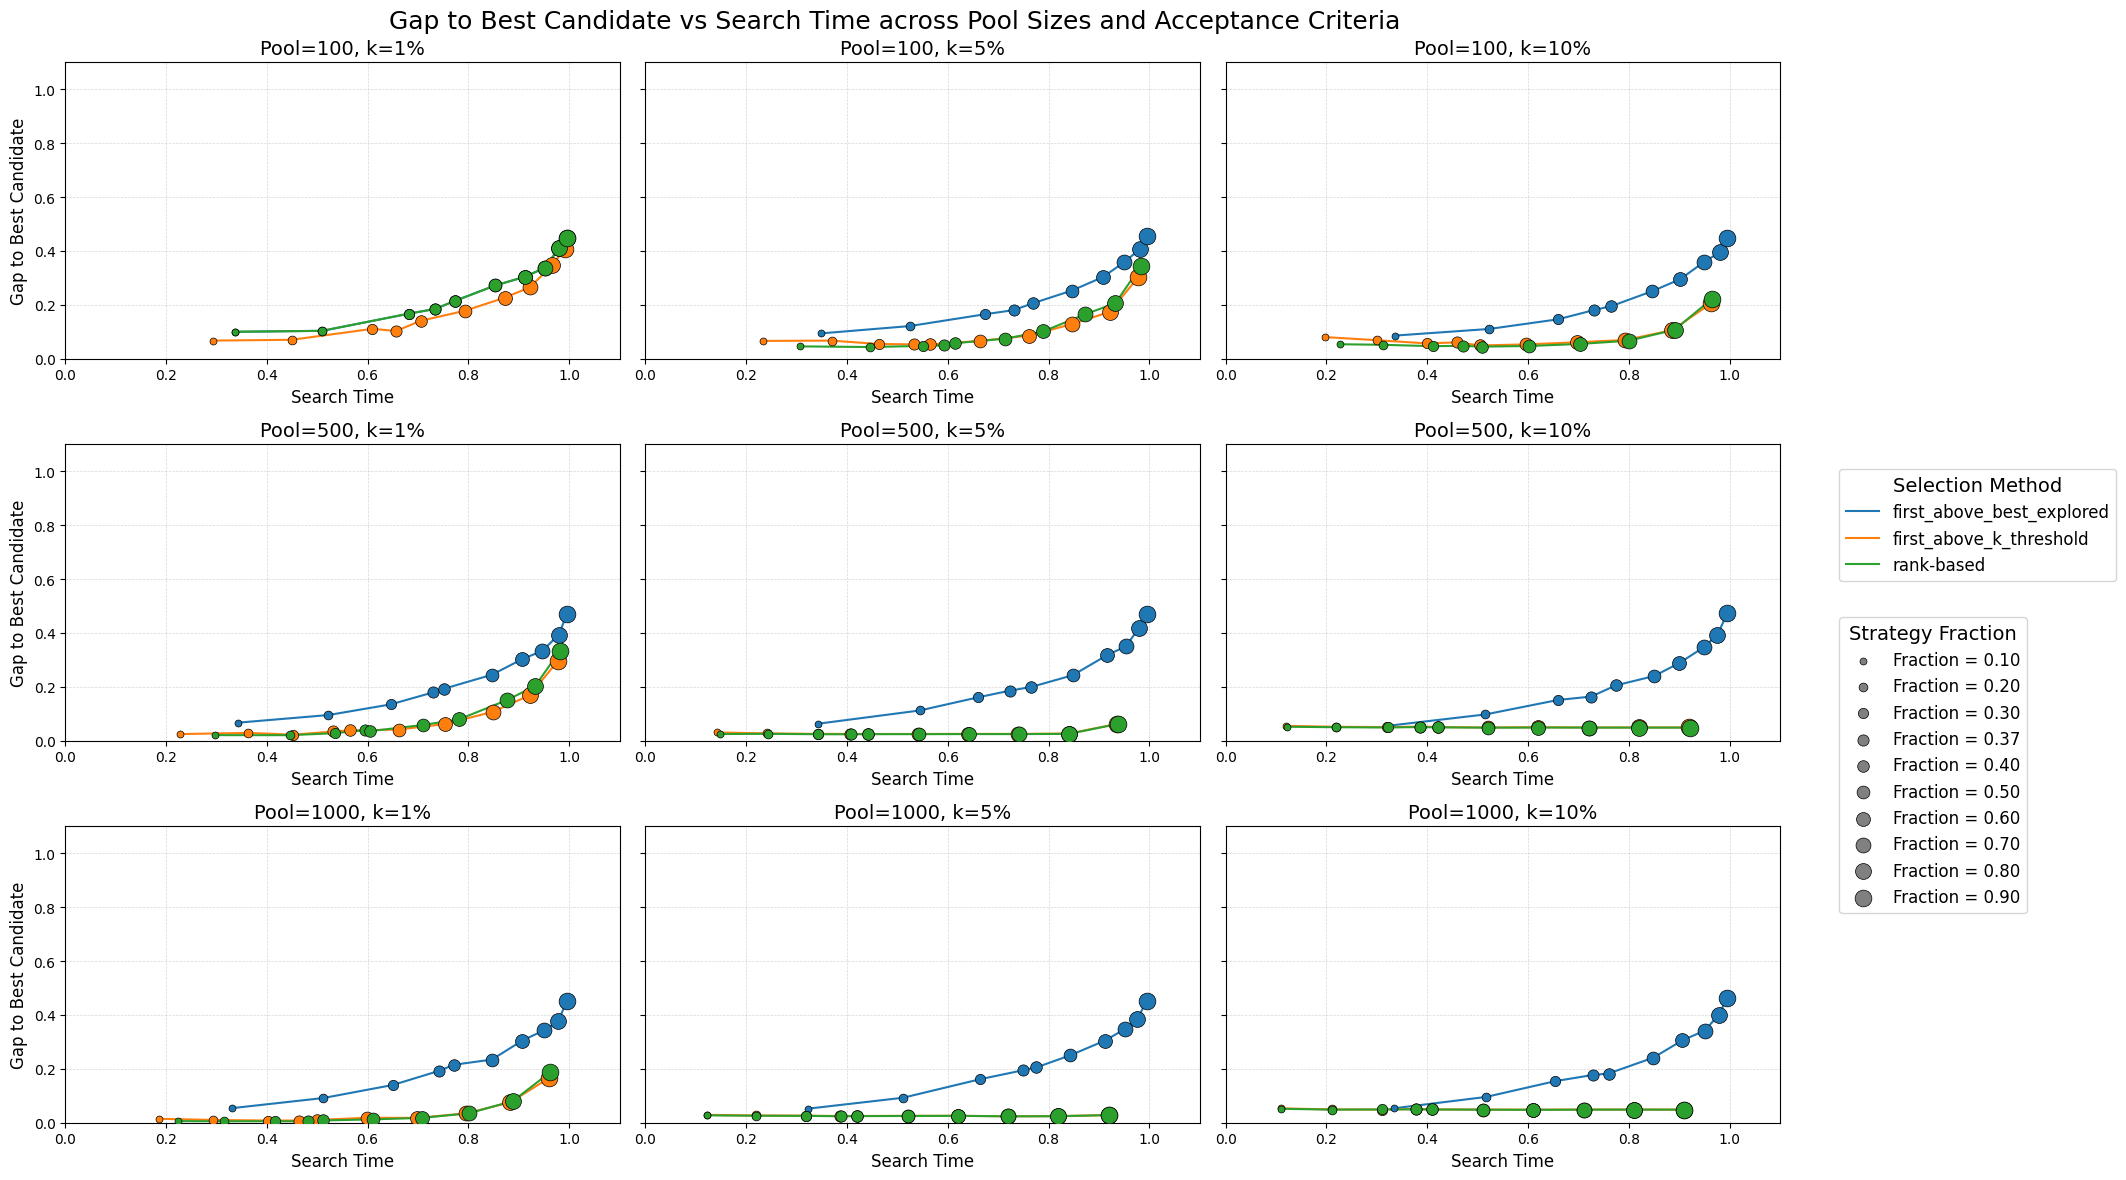

In [104]:
def plot_gap_vs_search_time(summary_df):
    pool_sizes = [100, 500, 1000]
    k_values = [0.01, 0.05, 0.10]
    selection_methods = summary_df['selection_method'].unique()
    fractions = sorted(summary_df['strategy_fraction'].unique())

    def size_from_fraction(frac):
        return 10 + frac * 150

    fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=False, sharey=True)
    fig.suptitle("Gap to Best Candidate vs Search Time across Pool Sizes and Acceptance Criteria", fontsize=18)
    line_handles, line_labels = [], []

    # -----------------------
    # DRAW SUBPLOTS
    # -----------------------
    for i, pool in enumerate(pool_sizes):
        for j, k in enumerate(k_values):
            
            ax = axes[i, j]
            sub = summary_df[(summary_df.pool_size == pool) & (summary_df.k_percent == k)]
            
            for method in selection_methods:


                sub_method = sub[sub.selection_method == method].sort_values("strategy_fraction")

                # line 
                line = sns.lineplot(
                    data=sub_method,
                    x='avg_search_time',
                    y='avg_gap_to_best',
                    ax=ax,
                    label=method,
                    legend=False
                )
                # save line legend ONCE
                if method not in line_labels:
                    line_handles.append(line.lines[-1])
                    line_labels.append(method)

                # markers
                for frac in fractions:
                    point = sub_method[sub_method.strategy_fraction == frac]
                    if len(point) == 0:
                        continue
                    
                    ax.scatter(
                        point['avg_search_time'],
                        point['avg_gap_to_best'],
                        s=size_from_fraction(frac),
                        color=line.lines[-1].get_color(),
                        edgecolor='black',
                        linewidth=0.5,
                        zorder=5
                    )

            ax.set_title(f"Pool={pool}, k={int(k*100)}%", fontsize=14)
            ax.set_ylim(0, 1.1)
            ax.set_xlim(0, 1.1)
            ax.set_xlabel("Search Time", fontsize=12)
            ax.set_ylabel("Gap to Best Candidate", fontsize=12)
            ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)


    # -----------------------
    # CREATE LEGEND
    # -----------------------


    # LINE LEGEND
    fig.legend(
        line_handles, line_labels,
        loc="center left",
        bbox_to_anchor=(1.02, 0.55),
        title="Selection Method",
        fontsize=12,
        title_fontsize=14
    )

    # MARKER LEGEND
    marker_handles = []
    marker_labels = []

    for frac in fractions:
        dummy = plt.scatter(
            [], [], 
            s=size_from_fraction(frac),
            color="gray",
            edgecolor="black",
            linewidth=0.5
        )
        marker_handles.append(dummy)
        marker_labels.append(f"Fraction = {frac:.2f}")

    fig.legend(
        marker_handles, marker_labels,
        loc="center left",
        bbox_to_anchor=(1.02, 0.35),
        title="Strategy Fraction",
        fontsize=12,
        title_fontsize=14
    )

    plt.tight_layout()
    plt.show()
plot_gap_vs_search_time(summary_df)

**1. Is the current selection strategy good enough? Is there a need for revising the selection strategy?**
**How does the strategy affect the search time and gap between selected candidate to the best one?**


***The classical strategy is not good enough and should be revised.***

Across all pool sizes and acceptance thresholds, the classical strategy (**first_above_best_explored**) performs systematically worse than the two revised strategies:

**(A) Success Rate**

- The blue curve is consistently below the orange and green curves in every subplot.
- As search time approaches 1.0 (i.e., the algorithm waits too long), the classical method exhibits a steep decline in success rate.
- The revised strategies maintain high success rates even at higher search times.

**(B) Gap to Best Candidate**

The gap plots clearly show:

- The classical method exhibits a much larger gap to the best candidate, especially at high search times.
- For the rank-based method, the gap remains close to zero for most of the domain, particularly in medium and large pools.
- Even the k-threshold method maintains a substantially lower gap compared to the classical rule.

**(C) Search Time Sensitivity**

- The classical strategy deteriorates sharply when search time exceeds ~0.8.
- Revised strategies are far more stable, showing slower degradation.

**Overall interpretation**

The classical strategy was optimal for selecting the single best candidate, but with the new “good-enough” objective, it becomes too conservative and frequently ends up selecting late-arriving low-quality candidates.
Thus, revising the strategy is necessary. Both revised strategies, especially the rank-based approach, significantly improve performance.

**2. How the acceptance threshold affects search time?**

Across columns (1%, 5%, 10%), several patterns emerge:

**(A) Higher k makes the problem easier**

When k increases from 1% → 5% → 10%, all strategies show:

- Higher success rates

- Lower gap to the best candidate

- Flatter curves (less sensitivity to search time)

**(B) Rank-based strategy becomes nearly perfect**

For k = 10%, rank-based success rates approach 1.0 across almost the entire search-time range in medium and large pools.

**Interpretation**

Relaxing the decision criterion (moving from "top 1%" to "top 10%") reduces risk and substantially boosts performance, but the relative ordering of the strategies remains the same:
Rank-based > k-threshold > classical.

**3. How pool size (100, 500, 1000) influences these patterns?**

**(A) Small pool (n = 100)**
- High variance and noisy patterns.

- Differences between strategies are less pronounced.

- Estimates of threshold or rank are unstable.

**(B) Medium pool (n = 500)**

- Curves smooth out; performance becomes more predictable.

- Rank-based method clearly outperforms the others.

- Classical strategy begins to lag significantly.

**(C) Large pool (n = 1000)**

- Success Rate shows clear separation of strategies:

  - Rank-based nearly saturates success (≥ 90–100%).

  - Threshold-based remains strong and stable.

  - Classical deteriorates sharply for large search times.

- Gap-to-best collapses towards zero for the rank-based method.

**Interpretation**

- As pool size increases:

  - Exploration becomes more informative

  - Strategy performance becomes more consistent

  - Advantage of revised strategies grows stronger and classical strategy becomes increasingly unsuitable

- The rank-based strategy scales best with pool size because it uses real-time updates, allowing it to adapt as information accumulates.